In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [2]:
# Load the full CI logs dataset
df = pd.read_csv("../data/all_logs.csv")

# Normalize column names to lowercase
df.columns = df.columns.str.lower()

print(df.columns)

# Preview structure
df.head()


Index(['timestamp', 'command', 'duration_s', 'exit_code', 'cpu_pct_avg',
       'mem_kb_max', 'tag', 'status', 'pipeline_id', 'mode'],
      dtype='object')


,timestamp,command,duration_s,exit_code,cpu_pct_avg,mem_kb_max,tag,status,pipeline_id,mode
0,2025-06-15 07:17:52,"docker login -u ""gitlab-ci-token"" -p ""glcbt-ey...",0.50,0,6.10,0,unknown,pass,1.870500e+09,baseline
1,2025-06-15 07:19:14,"docker build -t ""registry.gitlab.com/uhthesis/...",82.14,0,40.59,46396,unknown,pass,1.870500e+09,baseline
2,2025-06-15 07:20:06,"docker push ""registry.gitlab.com/uhthesis/bids...",51.59,0,55.48,37844,unknown,pass,1.870500e+09,baseline
3,2025-06-15 07:21:05,flake8 .,1.00,0,48.15,22600,unknown,pass,1.870500e+09,baseline
4,2025-06-15 07:22:02,python manage.py collectstatic --noinput,0.50,0,35.40,0,unknown,pass,1.870500e+09,baseline


In [3]:
# Drop columns we don't want
df = df.drop(columns=["command", "exit_code"])

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Drop timestamp if you don't need time-series modeling
# df = df.drop(columns=["timestamp"])

# Convert memory to MB
df["mem_mb"] = df["mem_kb_max"] / 1024
df.drop(columns=["mem_kb_max"], inplace=True)

# Log-transform duration
df["log_duration"] = np.log1p(df["duration_s"])
df.drop(columns=["duration_s"], inplace=True)

# Encode tag (CI stage)
df["tag_code"] = df["tag"].astype("category").cat.codes
df.drop(columns=["tag"], inplace=True)

# Encode target
df["status"] = df["status"].map({"pass": 1, "fail": 0})

# Final preview
df.head()

# result - 6 columns representing the 6 input features
# tag column refers to the CI job type - 0 = build, 1 = lint, 2 = test


,timestamp,cpu_pct_avg,status,pipeline_id,mode,hour,dayofweek,mem_mb,log_duration,tag_code
0,2025-06-15 07:17:52,6.10,1,1.870500e+09,baseline,7,6,0.000000,0.405465,3
1,2025-06-15 07:19:14,40.59,1,1.870500e+09,baseline,7,6,45.308594,4.420526,3
2,2025-06-15 07:20:06,55.48,1,1.870500e+09,baseline,7,6,36.957031,3.962526,3
3,2025-06-15 07:21:05,48.15,1,1.870500e+09,baseline,7,6,22.070312,0.693147,3
4,2025-06-15 07:22:02,35.40,1,1.870500e+09,baseline,7,6,0.000000,0.405465,3


In [4]:
# Select features for model (exclude pipeline_id!)
features = ["log_duration", "cpu_pct_avg", "mem_mb", "tag_code", "hour", "dayofweek"]
X = df[features]
y = df["status"]

print("NaNs in X:\n", X.isnull().sum())

mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

# result - example: ((231, 6), (58, 6)) = 231 samples in the training set, 58 samples in the test set, Each with 6 features


NaNs in X:
 log_duration    0
cpu_pct_avg     0
mem_mb          0
tag_code        0
hour            0
dayofweek       0
dtype: int64


((309, 6), (78, 6))

In [5]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=["fail", "pass"]))


Logistic Regression Performance
              precision    recall  f1-score   support

        fail       0.24      1.00      0.39        10
        pass       1.00      0.54      0.70        68

    accuracy                           0.60        78
   macro avg       0.62      0.77      0.55        78
weighted avg       0.90      0.60      0.66        78



In [6]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=["fail", "pass"]))


Random Forest Performance
              precision    recall  f1-score   support

        fail       0.78      0.70      0.74        10
        pass       0.96      0.97      0.96        68

    accuracy                           0.94        78
   macro avg       0.87      0.84      0.85        78
weighted avg       0.93      0.94      0.93        78



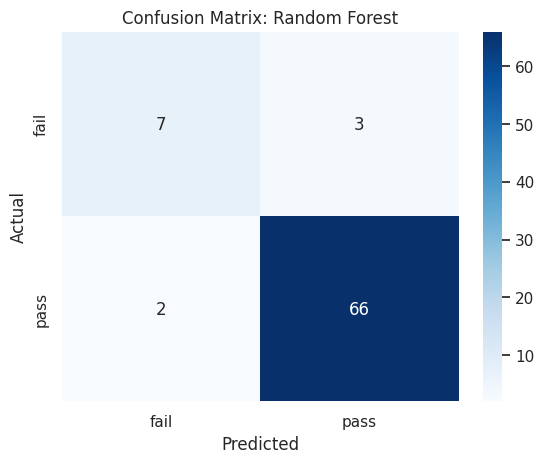

In [7]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["fail", "pass"], yticklabels=["fail", "pass"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [8]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb, target_names=["fail", "pass"]))

XGBoost Performance
              precision    recall  f1-score   support

        fail       0.53      0.90      0.67        10
        pass       0.98      0.88      0.93        68

    accuracy                           0.88        78
   macro avg       0.76      0.89      0.80        78
weighted avg       0.93      0.88      0.90        78



In [9]:
# 1) Prepare data for AE
from sklearn.preprocessing import StandardScaler
scaler_ae = StandardScaler()
X_scaled = scaler_ae.fit_transform(X)            # scale all features
X_train_ae = X_scaled[y == 1]                    # train only on pass jobs

# 2) Build AE
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_train_ae.shape[1]
encoding_dim = max(2, input_dim // 2)

ae = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])
ae.compile(optimizer="adam", loss="mse")

# 3) Train AE
history = ae.fit(
    X_train_ae, X_train_ae,
    epochs=30,
    batch_size=8,
    validation_split=0.1,
    verbose=1
)

# 4) Compute reconstruction error
recon = ae.predict(X_scaled)
mse = np.mean((X_scaled - recon)**2, axis=1)
df["recon_err"] = mse

# 5) Choose threshold and predict anomalies
thr = np.percentile(df.loc[y == 1, "recon_err"], 95)
df["ae_pred"] = (df["recon_err"] > thr).astype(int)  # 1 = anomaly (fail)
df["ae_pred"] = df["ae_pred"].map({1: 0, 0: 1})       # align: 1=pass, 0=fail

# 6) Evaluate
from sklearn.metrics import classification_report
print("Autoencoder Performance")
print(classification_report(y, df["ae_pred"], target_names=["fail","pass"]))


2025-06-26 13:43:48.063042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750945428.264536    7770 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750945428.334420    7770 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750945428.990470    7770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750945428.990506    7770 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750945428.990509    7770 computation_placer.cc:177] computation placer alr

Epoch 1/30


2025-06-26 13:43:52.022158: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8804 - val_loss: 1.9559
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8367 - val_loss: 1.7919
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5139 - val_loss: 1.6829
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5482 - val_loss: 1.5804
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3851 - val_loss: 1.5069
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3201 - val_loss: 1.4431
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2239 - val_loss: 1.3926
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2644 - val_loss: 1.3479
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2180 - val_loss: 1.3112
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1697 - val_loss: 1.2839
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1283 - val_loss: 1.2523
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1252 - val_loss: 1.2324


In [10]:
#print(df.columns)
print(df.columns.tolist())

['timestamp', 'cpu_pct_avg', 'status', 'pipeline_id', 'mode', 'hour', 'dayofweek', 'mem_mb', 'log_duration', 'tag_code', 'recon_err', 'ae_pred']


In [11]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# 1) Build sequences
seq_len = 3
features = ["log_duration", "cpu_pct_avg", "mem_mb", "tag_code"]
pipelines = []
labels = []

for pid, group in df.reset_index().groupby("pipeline_id"):
    grp = group.sort_values("timestamp")
    feats = grp[features].values
    lbls = grp["status"].values
    # take the last status as pipeline label (fail if any job failed)
    pipeline_label = int((lbls == 1).all())
    # pad or truncate to seq_len
    if feats.shape[0] < seq_len:
        pad = np.zeros((seq_len - feats.shape[0], feats.shape[1]))
        feats = np.vstack([feats, pad])
    else:
        feats = feats[:seq_len]
    pipelines.append(feats)
    labels.append(pipeline_label)

X_seq = np.stack(pipelines)    # shape: (n_pipelines, seq_len, n_features)
y_seq = np.array(labels)

# 2) Train/test split on pipelines
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# 3) Build LSTM model
model = models.Sequential([
    layers.Input(shape=(seq_len, len(features))),
    layers.LSTM(16, return_sequences=False),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# 4) Train LSTM
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=20,
    batch_size=4,
    verbose=1
)

# 5) Evaluate
y_pred_seq = (model.predict(X_te) > 0.5).astype(int).flatten()
from sklearn.metrics import classification_report
print("LSTM Performance")
print(classification_report(y_te, y_pred_seq, target_names=["fail","pass"]))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,489 (5.82 KB)

 Trainable params: 1,489 (5.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7026 - loss: 0.6802 - val_accuracy: 0.6000 - val_loss: 0.6663
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6119 - loss: 0.6616 - val_accuracy: 0.6000 - val_loss: 0.6180
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6332 - loss: 0.6133 - val_accuracy: 0.8000 - val_loss: 0.5916
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6878 - loss: 0.5782 - val_accuracy: 0.7333 - val_loss: 0.5634
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7864 - loss: 0.5390 - val_accuracy: 0.7333 - val_loss: 0.5421
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7158 - loss: 0.5273 - val_accuracy: 0.7333 - val_loss: 0.5237
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7412 - loss: 0.5181 - val_accuracy: 0.7333 - val_loss: 0.5069
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7726 - loss: 0.4678 - val_accuracy: 0.7333 - val_loss

In [12]:
importances = rf.feature_importances_
features = X_train.columns

for feat, score in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(f"{feat:15} → {score:.3f}")

cpu_pct_avg     → 0.424
mem_mb          → 0.197
log_duration    → 0.158
hour            → 0.128
tag_code        → 0.054
dayofweek       → 0.040


In [17]:
import joblib
from sklearn.preprocessing import StandardScaler

# 1. Save Random Forest model
joblib.dump(rf, "models/rf_model.joblib")

# 2. Fit & save scaler (only if you scaled RF inputs)
scaler_rf = StandardScaler().fit(X_train)
joblib.dump(scaler_rf, "models/rf_scaler.joblib")

# 3. Save LSTM in new format
model.save("models/lstm_model.keras")
